In [2]:
#Nicole Zawadzki
#Homework 7
#ASTR400b 
#Plot the furture orbit of M33's orbit around M31

In [3]:
#import modules
import numpy as np
import astropy.units as u

#plotting modules
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')


In [4]:
#import necessary files
from ReadFile import *
from CenterOfMass import *

In [5]:
#define class that will create series of functions to determine acceleration M33 feels from M31 and 
#integreate position and velocity forwards in time
class M33AnalyticOrbit:
    #input filename for file where integration orbit will be stored
    def __init__(self, filename):
        #initialize COM position vectors of M33 relative to M31 using disk particles
        #read in COM data files for M31 and M33
        self.fM31 = np.genfromtxt('Orbit_M31.txt',dtype=None,names=True)
        self.fM33 = np.genfromtxt('Orbit_M33.txt',dtype=None,names=True)
        
        #position vectors for Snapshot 0
        self.x = (self.fM33['x'][0]-self.fM31['x'][0])
        self.y = (self.fM33['y'][0]-self.fM31['y'][0])
        self.z = (self.fM33['z'][0]-self.fM31['z'][0])
        #print 'positions', self.x, self.y, self.z
        #velocity vectors for snapshot 0
        self.vx = (self.fM33['vx'][0]-self.fM31['vx'][0])
        self.vy = (self.fM33['vy'][0]-self.fM31['vy'][0])
        self.vz = (self.fM33['vz'][0]-self.fM31['vz'][0])
        #print 'velocities', self.vx, self.vy, self.vz
        
        #disk scale length
        self.rd = 5 #kpc
        
        #disk mass --value taken from Homework 3
        self.MdiskM31 = 0.12e12 #Msun
        
        #buldge scale length
        self.rbuldge = 1 #kpc
        
        #buldge mass --value taken from Homework 3
        self.MbuldgeM31 = 0.019e12 #Msun
        
        #Halo scale length using Hernquist scale length
        self.rhaloM31 = 62 #kpc
        
        #halo mass --value taken from Homework 3
        self.MhaloM31 = 1.921e12 #Msun
        
        #define gravitational constant
        self.G = 4.498768e-6 #kpc^3/Msun/Gyr
    
    #function to find the acceleration from Hernquist potential
    #Use this function to find halo and buldge acceleration of M31
    def HernquistAccel(self,M,ra,x,y,z,n):
        #input: scale length, mass, coordinates, and a dummy variable to indicate which component 
        #of accel is needed
        #returns:acceleration from Hernquist potential in direction of dummy variable
        r = np.sqrt(x**2 + y**2 + z**2)
        a = -(self.G*M/(r*(ra+r)**2))*n
        
        return a
    
    #approximation that mimics Miyamoto-Nagai 1975 potential
    #MN potential = -G*Mdisk/(sqrt(R**2+(rd+sqrt(z**2+zd**2))**2)
    #Use to find disk acceleration of M31
    def MiyamotoNagaiAccel(self,M,rd,x,y,z,n):
        #input: mass, disk scale length, coordinates, and a dummy variable to indicate which component
        #of accel is needed
        #returns: acceleration from Miamoto-Nagai potential in direction of dummy variable
        
        #define variables needed for equations
        R = np.sqrt(x**2 + y**2)
        zd = self.rd/5 #disk scale height
        B = rd + np.sqrt(z**2 + zd**2)
        #different solution for acceleration in the z direction
        #need to make sure appropriate accel is used depending on inout of n (dummy variable)
        if n==x or n==y:
            a = -(self.G*M/(R**2+B**2)**1.5)*n
        else:
            a = -(self.G*M*B/((R**2 + B**2)**1.5*np.sqrt(z**2 + zd**2)))*n
        
        return a
    
    #sum acceleration from each component of the galaxy
    def M31Accel(self,x,y,z,n):
        #input: coordinates and dummy variable for which compnent of accel is of interest
        #return: sum of accel for each galaxy component in direction of dummy variable
        #do the hernquist twice because used for halo and buldge
        a = self.HernquistAccel(self.MhaloM31,self.rhaloM31,x,y,z,n) + self.HernquistAccel(self.MbuldgeM31,self.rbuldge,x,y,z,n) + self.MiyamotoNagaiAccel(self.MdiskM31,self.rd,x,y,z,n)
        
        return a
    
    #solve the orbit of M33 by integrating equation of motion forwards in time
    def LeapFrog(self,dt,x,y,z,vx,vy,vz):
        #input: time interval, starting positon and veloctiy vectors
        #return:updated position and velocity vectors after time interval
    
        #predict position of M33's COM at middle timestep using current COM vrelocity and position
        x_half = x + vx*dt/2.0 
        y_half = y + vy*dt/2.0
        z_half = z + vz*dt/2.0
        
        #advance COM position and velocity a full time step using acceleration at half time step
        vx2 = vx + self.M31Accel(x_half,y_half,z_half,x_half)*dt
        vy2 = vy + self.M31Accel(x_half,y_half,z_half,y_half)*dt
        vz2 = vz + self.M31Accel(x_half,y_half,z_half,z_half)*dt
        
        x2 = x + (1.0/2.0)*(vx+vx2)*dt
        y2 = y + (1.0/2.0)*(vy+vy2)*dt
        z2 = z + (1.0/2.0)*(vz+vz2)*dt
        #print self.M31Accel(x_half,y_half,z_half,x_half), self.M31Accel(x_half,y_half,z_half,y_half), self.M31Accel(x_half,y_half,z_half,z_half)
        return x2,y2,z2,vx2,vy2,vz2
    
    #loop over LeapFrog integrator to solve equations of motion
    def OrbitIntegrator(self,to,dt,tmax):
        #input: a starting time, time interval, and ending time
        #return: the orbit of M33 around M31 into the future stored in a data file
        #array to store updating position and velocity vectors
        orbit = np.zeros(shape=(int(tmax/dt)+2,7))
        #initialize M33 position and velocity relative to M31
        x = self.x
        y = self.y
        z = self.z
        vx = self.vx
        vy = self.vy
        vz = self.vz
        
        #store initial values in array
        orbit[0][0]=to
        orbit[0][1]=x
        orbit[0][2]=y
        orbit[0][3]=z
        orbit[0][4]=vx
        orbit[0][5]=vy
        orbit[0][6]=vz
        
        #loop over LeapFrog function starting at to, ending at tmax, at intervals of dt
        t=to
        #counter for indexing
        ind=1 
        while t<tmax:
            #run integrator
            Frog = self.LeapFrog(dt,x,y,z,vx,vy,vz)
        
            #print ind
            #store next values
            orbit[ind][0]=t+dt
            orbit[ind][1]=Frog[0]
            orbit[ind][2]=Frog[1]
            orbit[ind][3]=Frog[2]
            orbit[ind][4]=Frog[3]
            orbit[ind][5]=Frog[4]
            orbit[ind][6]=Frog[5]
            
            #reinitialize position and velocity vectors to loop over
            x = Frog[0]
            y = Frog[1]
            z = Frog[2]
            vx = Frog[3]
            vy = Frog[4]
            vz = Frog[5]
            
            #advance time and counter
            t=t+dt
            ind = ind+1
        
        #save array to a file
        np.savetxt('OrbitIntegrated.txt', orbit, header='t x y z vx vy vz', comments ='#', fmt=['%.2f', '%.2f', '%.2f', '%.2f', '%.2f', '%.2f', '%.2f'])
        return None
           

In [6]:
#create object for plotting analytic solutions
AnalyticObject = M33AnalyticOrbit('OrbitIntegrated.txt')


In [7]:
#run the integration of M33's orbit from time 0 to 10 Gyr
File = AnalyticObject.OrbitIntegrator(0,0.1,10)

In [8]:
#read back in data from integrator and simulation
OrbitFile = np.genfromtxt('OrbitIntegrated.txt',dtype=None,names=True)
M31SimFile = np.genfromtxt('Orbit_M31.txt',dtype=None,names=True)
M33SimFile = np.genfromtxt('Orbit_M33.txt',dtype=None,names=True)

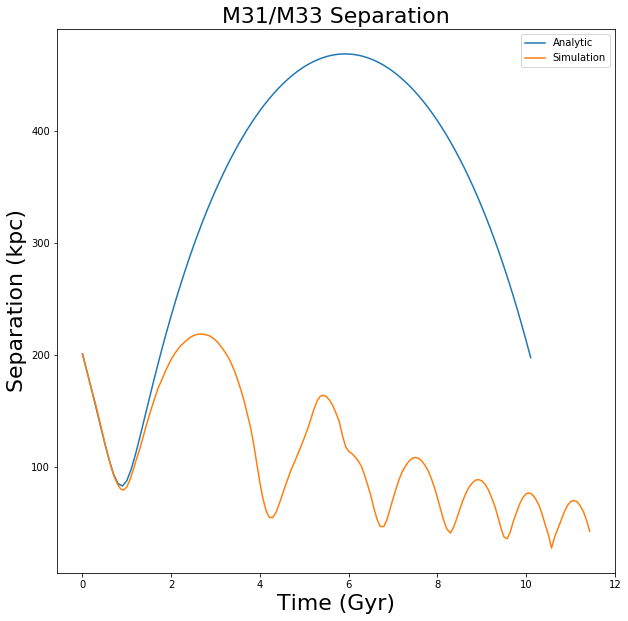

In [9]:
#plot position of M33 relative to M31 through time
time = OrbitFile['t']
position = np.sqrt(OrbitFile['x']**2 + OrbitFile['y']**2 + OrbitFile['z']**2)

#test print statement
#print(OrbitFile['x'][13])

#overplot position from simulation
simtime = M31SimFile['t']
simx = abs(M31SimFile['x']-M33SimFile['x'])
simy = abs(M31SimFile['y']-M33SimFile['y'])
simz = abs(M31SimFile['z']-M33SimFile['z'])
simr = np.sqrt(simx**2 + simy**2 + simz**2)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.plot(time,position,label='Analytic')
plt.plot(simtime,simr,label='Simulation')
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Separation (kpc)', fontsize=22)
plt.title('M31/M33 Separation', fontsize=22)
plt.legend()

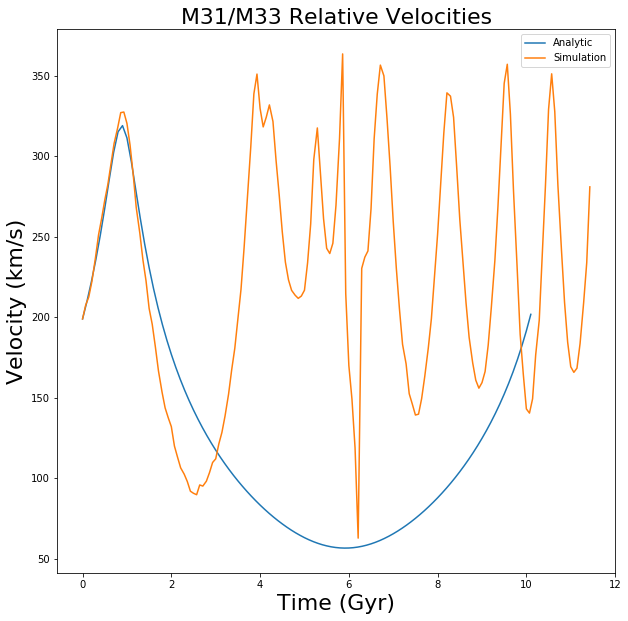

In [10]:
#plot velocity of M33 relative to M31
time = OrbitFile['t']
velocity = np.sqrt(OrbitFile['vx']**2 + OrbitFile['vy']**2 + OrbitFile['vz']**2)

#overplot velocity from simulation
simtime = M31SimFile['t']
simvx = abs(M31SimFile['vx']-M33SimFile['vx'])
simvy = abs(M31SimFile['vy']-M33SimFile['vy'])
simvz = abs(M31SimFile['vz']-M33SimFile['vz'])
simv = np.sqrt(simvx**2 + simvy**2 + simvz**2)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.plot(time,velocity,label='Analytic')
plt.plot(simtime,simv,label='Simulation')
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Velocity (km/s)', fontsize=22)
plt.title('M31/M33 Relative Velocities', fontsize=22)
plt.legend()

Questions:
2. For both plots the analytic solution is consistent with the simulation for the first Gyr. After the first pericenter the solutions diverge greatly. 
3. The analytic soultion assumes the the galaxies are point mass, and are missing the interactions of the particles with others in the galaxy.
4. The MW's gravitational affects become significant once it has merged with M31. A caveat can be out into the calculations for the acceleration of M31 that once time is greater than or equal to 6.2 Gyr, the time of the merger, the mass changes from just M31 to the mass of (M31+MW). 